In [1]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import seaborn as sns

In [2]:
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 5.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import en_core_web_sm
from spacy import displacy
from collections import Counter

In [5]:
data = []
with gzip.open('All_Beauty.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

371345
{'overall': 1.0, 'verified': True, 'reviewTime': '02 19, 2015', 'reviewerID': 'A1V6B6TNIC10QE', 'asin': '0143026860', 'reviewerName': 'theodore j bigham', 'reviewText': 'great', 'summary': 'One Star', 'unixReviewTime': 1424304000}


In [6]:
df = pd.DataFrame.from_dict(data)

print(len(df))

371345


In [7]:
print(df)

        overall  verified   reviewTime      reviewerID        asin  \
0           1.0      True  02 19, 2015  A1V6B6TNIC10QE  0143026860   
1           4.0      True  12 18, 2014  A2F5GHSXFQ0W6J  0143026860   
2           4.0      True  08 10, 2014  A1572GUYS7DGSR  0143026860   
3           5.0      True  03 11, 2013   A1PSGLFK1NSVO  0143026860   
4           5.0      True  12 25, 2011   A6IKXKZMTKGSC  0143026860   
...         ...       ...          ...             ...         ...   
371340      1.0      True  07 20, 2017  A202DCI7TV1022  B01HJEGTYK   
371341      5.0      True  03 16, 2017  A3FSOR5IJOFIBE  B01HJEGTYK   
371342      5.0      True   03 1, 2017  A1B5DK6CTP2P24  B01HJEGTYK   
371343      2.0      True  02 21, 2017  A23OUYS5IRMJS9  B01HJEGTYK   
371344      2.0      True  12 15, 2016  A24KQ9RVU81L87  B01HJEGTYK   

             reviewerName                                         reviewText  \
0       theodore j bigham                                              great   

In [8]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4.0,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4.0,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN
3,5.0,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN
4,5.0,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN


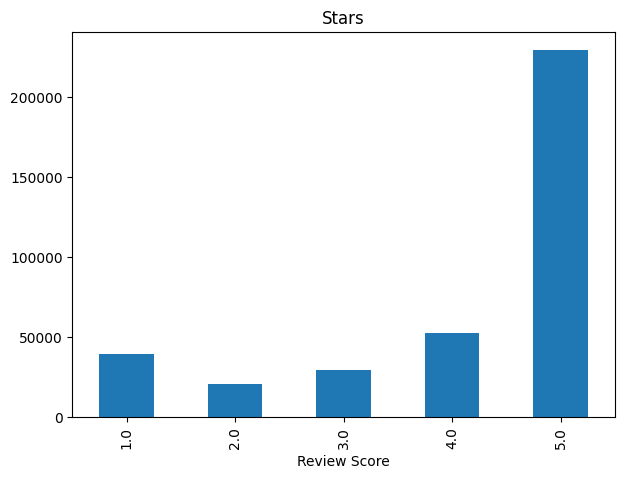

In [9]:
ax = df['overall'].value_counts().sort_index()\
    .plot(kind= 'bar', 
    title = 'Stars', 
    figsize=(7,5))
ax.set_xlabel('Review Score')
plt.show()

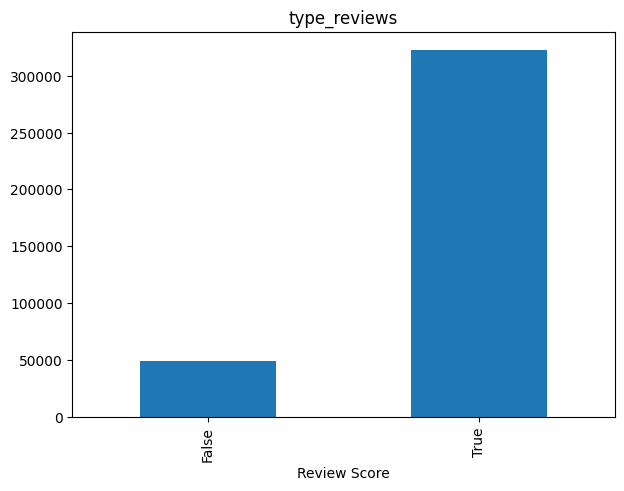

In [10]:
ax = df['verified'].value_counts().sort_index()\
    .plot(kind= 'bar', 
    title = 'type_reviews', 
    figsize=(7,5))
ax.set_xlabel('Review Score')
plt.show()

Without having eliminated fake reviews, the vast majority of reviews are positive with a ranking of 5, followed by a ranking of 4.

In [11]:
df.shape

(371345, 12)

In [12]:
df.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
style              object
image              object
dtype: object

In [13]:
amazon_re = df[['overall','reviewerID', 'verified', 'reviewText']].copy()


In [14]:
amazon_re.head()

,overall,reviewerID,verified,reviewText
0,1.0,A1V6B6TNIC10QE,True,great
1,4.0,A2F5GHSXFQ0W6J,True,My husband wanted to reading about the Negro ...
2,4.0,A1572GUYS7DGSR,True,"This book was very informative, covering all a..."
3,5.0,A1PSGLFK1NSVO,True,I am already a baseball fan and knew a bit abo...
4,5.0,A6IKXKZMTKGSC,True,This was a good story of the Black leagues. I ...


In [15]:
amazon_re = amazon_re.loc[amazon_re['verified'] != False]


In [16]:
amazon_re.shape

(322473, 4)

In [17]:
amazon_re.head()

,overall,reviewerID,verified,reviewText
0,1.0,A1V6B6TNIC10QE,True,great
1,4.0,A2F5GHSXFQ0W6J,True,My husband wanted to reading about the Negro ...
2,4.0,A1572GUYS7DGSR,True,"This book was very informative, covering all a..."
3,5.0,A1PSGLFK1NSVO,True,I am already a baseball fan and knew a bit abo...
4,5.0,A6IKXKZMTKGSC,True,This was a good story of the Black leagues. I ...


In [18]:
amazon_re.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322473 entries, 0 to 371344
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     322473 non-null  float64
 1   reviewerID  322473 non-null  object 
 2   verified    322473 non-null  bool   
 3   reviewText  322098 non-null  object 
dtypes: bool(1), float64(1), object(2)
memory usage: 10.1+ MB


Deleting NULL

In [19]:
filas_con_nulos = amazon_re.isnull().any(axis=1)


In [20]:
cantidad_filas_con_nulos = filas_con_nulos.sum()
print("Cantidad de filas con valores nulos:", cantidad_filas_con_nulos)


Cantidad de filas con valores nulos: 375


In [21]:
amazon_re = amazon_re.dropna()


In [22]:
filas_con_nulos = amazon_re.isnull().any(axis=1)
cantidad_filas_con_nulos = filas_con_nulos.sum()
print("Cantidad de filas con valores nulos:", cantidad_filas_con_nulos)

Cantidad de filas con valores nulos: 0


In [23]:
amazon_re.shape

(322098, 4)

In [24]:
amazon_re.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322098 entries, 0 to 371344
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     322098 non-null  float64
 1   reviewerID  322098 non-null  object 
 2   verified    322098 non-null  bool   
 3   reviewText  322098 non-null  object 
dtypes: bool(1), float64(1), object(2)
memory usage: 10.1+ MB


In [25]:
amazon_re.describe()['overall'].T

count    322098.000000
mean          4.113881
std           1.361587
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [26]:
amazon_re = amazon_re[['overall','reviewerID', 'reviewText']].copy()


In [27]:
X = amazon_re.reviewText.values

# Changes values from [0,4] to [0,1]
y = (amazon_re.overall.values > 1).astype(int)


# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [28]:
for s, l in zip(x_train_text[:5], y_train[:5]):
  print('{}: {}'.format(l, s))

1: As expected for price.
1: Have experienced no issues with leaking or otherwise.  Very happy with product.  Been using for 3 months now and still going strong.
1: Hands down this product is the best gel liner. Goes on like butter.
1: Buying this cape was very helpful especially haircutting a 3-1/2 yr old... The material is breathable and the hair slides from it. It is like the ones they use in a professional salon but only for kids. Goodluck everyone... hope this one help.
1: It's hard to find a good 5/8" curling iron - it must not be a popular size.  Some on the market have the thumb release so high from the barrel it's difficult to use.  The Helen of Troy is simple but effective.  Easy on the hands and has 2 heat settings - I only use the high setting.  I've tried other curling irons with temperature settings and they just burn my hair - no need for all the pizazz.  Just need a simple curling iron that works well and this one does the job.  The cord does curl up on you but for the 

Tokenization

In [39]:
tokenizer = get_tokenizer("basic_english")

print('Before Tokenize: ', x_train_text[1])
print('After Tokenize: ', tokenizer(x_train_text[1]))

Before Tokenize:  Have experienced no issues with leaking or otherwise.  Very happy with product.  Been using for 3 months now and still going strong.
After Tokenize:  ['have', 'experienced', 'no', 'issues', 'with', 'leaking', 'or', 'otherwise', '.', 'very', 'happy', 'with', 'product', '.', 'been', 'using', 'for', '3', 'months', 'now', 'and', 'still', 'going', 'strong', '.']


In [36]:
nlp = spacy.load('en_core_web_sm')


In [37]:
# Tokenize each review in the reviewText column

tokenized_train_reviews = []
